In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


In [2]:
data_url='http://anirut.space/data/decals_galaxy.fits'
hdul=fits.open(data_url)


In [3]:
data=pd.DataFrame(hdul[1].data)

In [4]:
z=data.spec_z

In [5]:
label=[]
for i,red in enumerate(z):
    if (red>0) & (red<=0.15):
        label.append(0)
    if (red>0.15) & (red<=0.30):
        label.append(1)
    if (red>0.30):
        label.append(2)    
data['label']=label

In [6]:
data['label'].value_counts()

0    296035
1     71545
2       827
Name: label, dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368407 entries, 0 to 368406
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   RA      368407 non-null  >f8  
 1   DEC     368407 non-null  >f8  
 2   MAG_G   368407 non-null  >f4  
 3   MAG_R   368407 non-null  >f4  
 4   MAG_Z   368407 non-null  >f4  
 5   spec_z  368407 non-null  >f4  
 6   label   368407 non-null  int64
dtypes: float32(4), float64(2), int64(1)
memory usage: 14.1 MB


In [8]:
data['G_R']=data.MAG_G-data.MAG_R
data['R_Z']=data.MAG_R-data.MAG_Z
data['G_Z']=data.MAG_G-data.MAG_Z

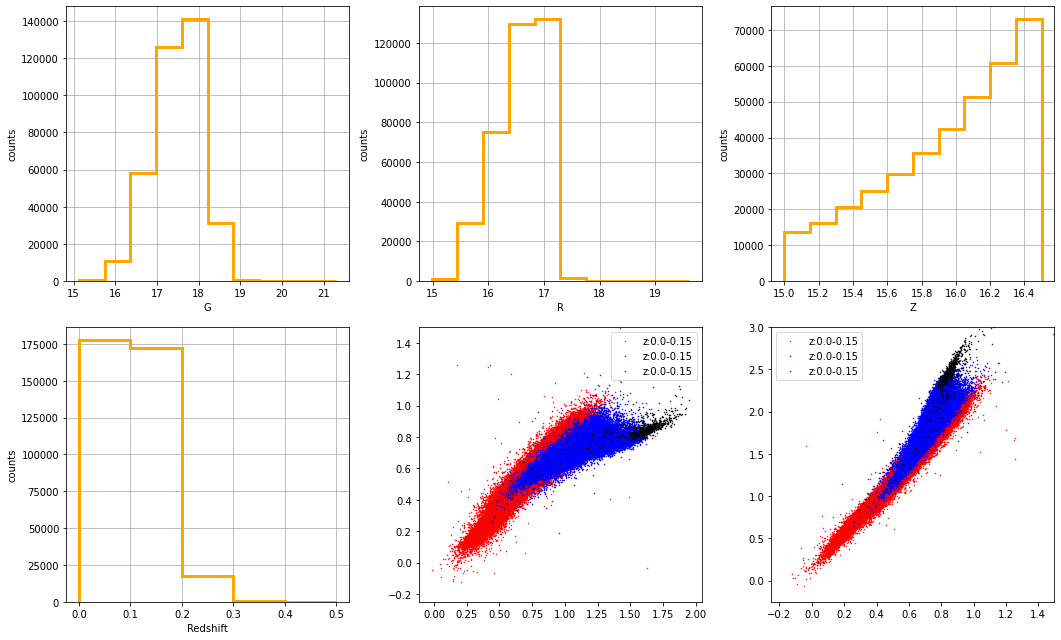

In [9]:
fig,ax=plt.subplots(2,3,figsize=[15,9])

ax[0,0].hist(data['MAG_G'],histtype='step',lw=3,color='orange')
ax[0,0].set_xlabel('G')
ax[0,0].set_ylabel('counts')
ax[0,0].grid()

ax[0,1].hist(data['MAG_R'],histtype='step',lw=3,color='orange')
ax[0,1].set_xlabel('R')
ax[0,1].set_ylabel('counts')
ax[0,1].grid()

ax[0,2].hist(data['MAG_Z'],histtype='step',lw=3,color='orange')
ax[0,2].set_xlabel('Z')
ax[0,2].set_ylabel('counts')
ax[0,2].grid()

ax[1,0].hist(data['spec_z'],bins=[0,0.1,0.20,0.3,0.4,0.5],lw=3,color='orange',histtype='step')
ax[1,0].set_xlabel('Redshift')
ax[1,0].set_ylabel('counts')
ax[1,0].grid()

ax[1,1].plot(data.loc[data.label==0,'G_R'],data.loc[data.label==0,'R_Z'],'r.',markersize=1,label='z:0.0-0.15')
ax[1,1].plot(data.loc[data.label==1,'G_R'],data.loc[data.label==1,'R_Z'],'b.',markersize=1,label='z:0.0-0.15')
ax[1,1].plot(data.loc[data.label==2,'G_R'],data.loc[data.label==2,'R_Z'],'k.',markersize=1,label='z:0.0-0.15')
ax[1,1].set_ylim(-0.25,1.5)
ax[1,1].legend()

ax[1,2].plot(data.loc[data.label==0,'R_Z'],data.loc[data.label==0,'G_Z'],'r.',markersize=1,label='z:0.0-0.15')
ax[1,2].plot(data.loc[data.label==1,'R_Z'],data.loc[data.label==1,'G_Z'],'b.',markersize=1,label='z:0.0-0.15')
ax[1,2].plot(data.loc[data.label==2,'R_Z'],data.loc[data.label==2,'G_Z'],'k.',markersize=1,label='z:0.0-0.15')
ax[1,2].set_ylim(-0.25,3)
ax[1,2].set_xlim(-0.25,1.5)
ax[1,2].legend()

plt.tight_layout()
plt.show()

In [10]:
features=data[['MAG_G','MAG_R','MAG_Z','G_R','R_Z','G_Z']]
labels=data['spec_z']

In [22]:
features

,MAG_G,MAG_R,MAG_Z,G_R,R_Z,G_Z
0,18.051302,16.650379,15.855108,1.400923,0.795271,2.196194
1,16.099888,15.692720,15.505195,0.407167,0.187526,0.594693
2,17.903336,16.801167,15.951186,1.102169,0.849980,1.952149
3,18.214943,17.124458,16.231075,1.090485,0.893383,1.983868
4,17.499908,16.558542,15.861851,0.941366,0.696692,1.638058
...,...,...,...,...,...,...
368402,18.313358,16.991161,16.263514,1.322197,0.727648,2.049845
368403,17.183678,16.290462,15.643917,0.893215,0.646545,1.539761
368404,18.394318,17.245005,16.424355,1.149313,0.820650,1.969963
368405,17.981689,16.917412,16.189604,1.064278,0.727808,1.792086


In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features,labels, test_size=0.2)

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

2021-08-12 17:17:00.241107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-12 17:17:00.241205: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
model = tf.keras.Sequential()
model.add(Dense(16, input_dim=6, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(0.001), loss="mse",metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                112       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


2021-08-12 17:17:03.897823: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-12 17:17:03.954919: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-12 17:17:03.954988: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vysakh-TUF-GAMING-FX504GD-FX80GD): /proc/driver/nvidia/version does not exist
2021-08-12 17:17:03.955837: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
save_log = model.fit(x_train, y_train,validation_split=0.3, epochs=50, batch_size=64)

2021-08-12 17:17:04.709382: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-12 17:17:04.729675: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299965000 Hz


Epoch 1/50
3224/3224 [==============================] - 14s 4ms/step - loss: 0.0673 - mse: 0.0673 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 2/50
3224/3224 [==============================] - 13s 4ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 3/50
3224/3224 [==============================] - 13s 4ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 4/50
3224/3224 [==============================] - 13s 4ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 5/50
3224/3224 [==============================] - 13s 4ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 6/50
3224/3224 [==============================] - 13s 4ms/step - loss: 9.8386e-04 - mse: 9.8386e-04 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 7/50
3224/3224 [==============================] - 13s 4ms/step - loss: 9.5854e-04 - mse: 9.5854e-04 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 8/50
3224/3224 [=================

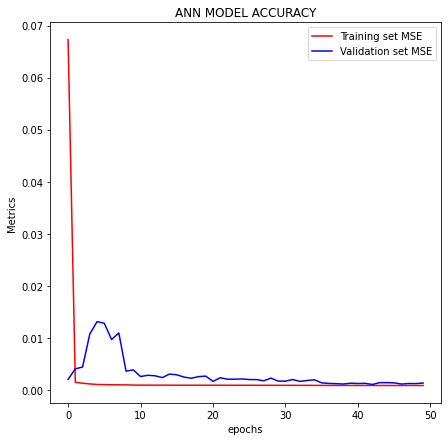

In [15]:
plt.figure(figsize=[7,7])
plt.plot(save_log.history['mse'],color='Red',label='Training set MSE')
plt.plot(save_log.history['val_mse'],color='Blue',label='Validation set MSE')
plt.title('ANN MODEL ACCURACY')
plt.xlabel("epochs")
plt.ylabel("Metrics")
plt.legend(loc = 'best')
plt.show()

In [16]:
Z_pred=model.predict(x_test)[:,0]

In [17]:
model.save("model.hdf5", overwrite=True, include_optimizer=True,
save_format=None, signatures=None, options=None)

In [18]:
std_test=[]
for i in range(len(x_test)):
    std_test.append(np.abs(Z_pred[i]-y_test.array[i])/(1+y_test.array[i]))

In [19]:
standard_dev=np.std(std_test)
mean=np.mean(Z_pred-y_test)

In [20]:
print('Mean:',mean)
print('Standard deviation:',standard_dev)

Mean: -0.011605454
Standard deviation: 0.01795422606164267


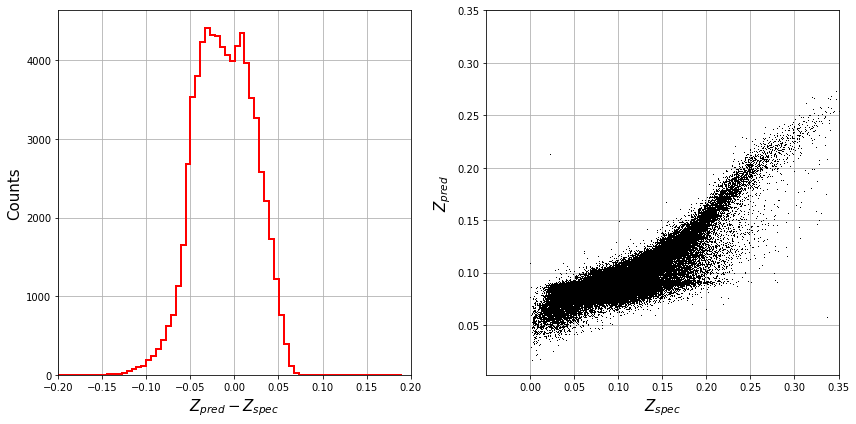

In [21]:
fig,ax=plt.subplots(1,2,figsize=[12,6])
ax[0].hist(Z_pred-y_test.array,bins=200,histtype='step',lw=2,color='red')
ax[0].set_xlim(-0.2,0.2)
ax[0].set_xlabel('$Z_{pred}-Z_{spec}$',fontsize=15)
ax[0].set_ylabel('Counts',fontsize=15)
ax[0].grid()

ax[1].plot(y_test,Z_pred,'k,')
ax[1].set_xlim(xmax=0.35)
ax[1].set_ylim(ymax=0.35)
ax[1].grid()
ax[1].set_xlabel('$Z_{spec}$',fontsize=15)
ax[1].set_ylabel('$Z_{pred}$',fontsize=15)
plt.tight_layout()
plt.show()